# Comparaison reco

In [1]:
from utils.collaborative import *

In [2]:
path = '/Vrac/PLDAC_addic7ed/ratings/ratings_60'

In [3]:
d_user = dict() #{username : {serie: note, serie : note}}

for user in sorted(os.listdir(path)):
    username = re.sub(".txt", "", user)
    d_user[username] = dict()
    with open(path+"/"+user) as file: 
        lignes = file.readlines()
        for ligne in lignes :
            serie, rating = ligne.split(" ")
            rating = rating.rstrip("\n")
            rating = float(rating)
            
            d_user[username][serie] = rating

In [4]:
liste_series = set()
for username, d_s in d_user.items() :
    for serie, rating in d_s.items() :
        liste_series.add(serie)
liste_series = list(liste_series)
len(liste_series)

1357

In [5]:
data = []
for username, d_s in d_user.items() :
    for serie, rating in d_s.items() :
        data.append( (username, serie, rating) )

In [6]:
# We first remap users and item to ids between (0,len(user)) and (0,len(item))
u_dic = {} #{username : user id}
i_dic = {} #{item title : item id}
        
all_data = [] #[(user id, item id, rating)]
    
d_username_id = dict()
d_itemname_id = dict()
for uid,iid,rating in data:  # iterating on all data
    
    uk = u_dic.setdefault(uid,len(u_dic))
    ik = i_dic.setdefault(iid,len(i_dic))
    all_data.append((uk,ik,float(rating)))
    d_username_id[uid] = uk
    d_itemname_id[iid] = ik

num_user = len(u_dic)
num_item = len(i_dic)

print(str(num_user)+" users and "+str(num_item)+" items.")

60 users and 1357 items.


In [7]:
# (1) Create sparse matrix from all ratings
Full = dok_matrix((num_user, num_item), dtype=np.float32)

for uid,iid,rating in all_data:
    Full[uid,iid] = float(rating)
    
    
# (2) Factorizing matrix

model = NMF(n_components=25, init='random', random_state=0, max_iter=350)
U = model.fit_transform(Full) #users
I = model.components_      #items

I = I.transpose()
I.shape


(1357, 25)

In [13]:
# We take 10% of the train set as test data
train_mat = dok_matrix((num_user, num_item), dtype=np.float32)
test = []
train = []
    
for i,(uid,iid,rating) in enumerate(all_data):
    if i%10 == 0: #one out of 10 is for test
        test.append((uid,iid,rating))
    else:
        train.append((uid,iid,rating))
        train_mat[uid,iid] = rating
    
print("Number of train examples: ", train_mat.nnz)
print("Number of test examples: ", len(test))

truth_tr = np.array([rating for (uid,iid),rating in train_mat.items()])
truth_te = np.array([rating for uid,iid,rating in test])

Number of train examples:  3305
Number of test examples:  368


In [9]:
A_orig = np.array(train_mat.todense())

#on remplace les zeros (notes absentes) par des NaN
for i in range(num_user):
    for j in range(num_item):
        if A_orig[i][j] == 0.0:
            A_orig[i][j] = np.NaN
            
A_df = pd.DataFrame(A_orig)
A_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1347,1348,1349,1350,1351,1352,1353,1354,1355,1356
0,NaN,7.0,8.0,10.0,10.0,8.0,8.0,10.0,10.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## NMF

In [14]:
max_comp = 200

n = []

test_mae_nmf = []

for i in range(10, max_comp, 10) :
    n.append(i)
    
    prediction_tr, prediction_te = predictions_NMF(train_mat, test, i, num_user, num_item)
    
    test_mae_nmf.append(MAE_err(prediction_te,truth_te))
    

## SVD

In [15]:
max_comp = 200

n = []

test_mae_svd = []


for i in range(10, max_comp, 10) :
    n.append(i)
    
    ## SVD Model
    model = TruncatedSVD(n_components=150)

    #get submatrices
    U_svd = model.fit_transform(train_mat)
    I_svd = model.components_.transpose()
    
    #predictions
    prediction_tr = np.array([pred_func_svd(U_svd, I_svd, u, i) for (u,i),rating in train_mat.items()])
    prediction_te = np.array([pred_func_svd(U_svd, I_svd, u, i) for u,i,rating in test])
    
    
    test_mae_svd.append(MAE_err(prediction_te,truth_te))


## mSVD

In [16]:
max_comp = 200

n = []

test_mae_msvd = []


for i in range(10, max_comp, 10) :
    n.append(i)
    
    # (1) compute mean of training ratings
    mean = np.mean([rating for (uid,iid),rating in train_mat.items()])


    # (2) mean normalize training matrix
    tmn = dok_matrix((num_user, num_item), dtype=np.float32)

    for (uid,iid), rating in train_mat.items():
        tmn[uid,iid] = rating - mean

    # (3) factorize matrix
    model_norm = TruncatedSVD(n_components=150)

    #get submatrices
    U_msvd = model.fit_transform(tmn)
    I_msvd = model.components_.transpose()


    prediction_tr = np.array([pred_func_msvd(U_msvd,I_msvd, u, i,mean) for (u,i),rating in train_mat.items()])
    prediction_te = np.array([pred_func_msvd(U_msvd, I_msvd, u, i, mean) for u,i,rating in test])

    
    test_mae_msvd.append(MAE_err(prediction_te,truth_te))

## kSVD

In [17]:
max_comp = 200

n = []

test_mae_ksvd = []


for i in range(10, max_comp, 10) :
    n.append(i)


    # (1) compute means of training set
    mean = mean

    # user and item deviation to mean
    u_means = {u:(np.mean(ratings - mean)) for u,ratings in group_by_user(train).items()}
    i_means = {i:(np.mean(ratings) - mean) for i,ratings in group_by_item(train).items()}


    # (2) normalize training matrix
    tmn_k = dok_matrix((num_user, num_item), dtype=np.float32)

    for (uid,iid), rating in train_mat.items():
        tmn_k[uid,iid] = rating - mean - u_means.get(uid,0) - i_means.get(iid,0)

    # (3) factorize matrix
    model_kor = TruncatedSVD(n_components=150)


    U_ksvd = model.fit_transform(tmn_k)
    I_ksvd = model.components_.transpose()


    prediction_tr = np.array([pred_func_ksvd(U_ksvd, I_ksvd, u, i, mean, u_means, i_means) for (u,i),rating in train_mat.items()])
    prediction_te = np.array([pred_func_ksvd(U_ksvd, I_ksvd, u, i, mean, u_means, i_means) for u,i,rating in test])
    
    
    test_mae_ksvd.append(MAE_err(prediction_te,truth_te))

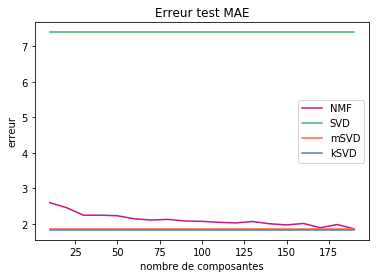

In [19]:
plt.plot(n, test_mae_nmf, label='NMF', color='mediumvioletred')
plt.plot(n, test_mae_svd, label='SVD', color='mediumseagreen')
plt.plot(n, test_mae_msvd, label='mSVD', color='tomato')
plt.plot(n, test_mae_ksvd, label='kSVD', color='steelblue')
plt.title("Erreur test MAE")
plt.xlabel("nombre de composantes")
plt.ylabel("erreur")
plt.legend()
plt.savefig("img/error/comparaison.png")
plt.show()